# MLFlow runs

In [1]:
import mlflow

mlflow.tracking.set_tracking_uri('../mlruns')

## Functions

In [2]:
from mlflow import MlflowClient

def get_runs(experiment_name, filter_string=''):
    client = MlflowClient()
    exp_ids = [client.get_experiment_by_name(experiment_name).experiment_id]
    runs = mlflow.search_runs(experiment_ids=exp_ids, filter_string=filter_string)
    return runs


def get_best_run(runs, best_metrics):
    if runs is None or runs.shape[0] == 0:
        return None
    for metric in best_metrics:
        runs = runs.loc[runs[f'metrics.{metric}'] >= runs[f'metrics.{metric}'].max()]
    # pick first in the list
    run = runs.loc[runs.index[0]]
    return run

In [3]:
def runs_to_latex(runs, threshold_method, caption, label):
    cols = ['tags.mlflow.runName', 'tags.model', 'tags.method', 'metrics.test_auc', 'metrics.test_tax_yield', 'metrics.test_tax_score', 'metrics.test_effort', 'metrics.test_f1-score_1', 'metrics.test_recall_1', 'metrics.test_precision_1', 'metrics.threshold']
    cols_renamed = [ 'name', 'model', 'method', 'auc', 'yield', 'value', 'effort', 'f1-score', 'recall', 'precision', 'threshold' ]
    to_replace = {
        'model': {'tree': 'DT', 'forest': 'RF', 'logit': 'LR'},
        'method': {'imbalanced': 'IM', 'oversample': 'RO', 'weighted': 'BC'}}
    df = runs.loc[:, :]
    df = df.loc[df['tags.threshold_method']==threshold_method]
    df = df.loc[df['tags.grouped']==str(grouped)]
    df = df.sort_index(ascending=False)
    df = df.loc[:, cols]
    df = df.rename(columns=dict(zip(cols, cols_renamed)))
    df = df.replace(to_replace=to_replace)
    df.loc[:, 'name'] = df.model.str.cat(df.method, sep='-')
    df = df.drop(columns=['model', 'method']).set_index(['name'])
    if threshold_method=='default':
        df = df.drop(columns=['threshold'])
    else:
        df = df.drop(columns=['auc'])
    cols_max = df.columns.drop('effort').tolist()
    s = df.style.highlight_max(subset=cols_max, axis=0, props='bfseries: ;')
    s = s.highlight_min(subset='effort', axis=0, props='bfseries: ;')
    latex_table = s.to_latex(
        column_format="lrrrrrrr", position="ht", position_float="centering",
        hrules=True, label=label, caption=caption,
        multirow_align="t", multicol_align="r")
    return latex_table

In [4]:
import matplotlib.pyplot as plt
import os, json

def get_mlflow_boxacc_prcurve(experiment_name = 'wsol2', dataset='SYNTHETIC', spec='d1b', archtype='cam', method=None):
    boxacc = {}
    prcurve = {}
    iou_thresholds = [30, 50, 70]
    filter_string = f'tags.dataset = "{dataset}" and status = "FINISHED" and tags.architecture_type = "{archtype}"'
    if method is not None:
        filter_string += f' and tags.method = "{method}"'
    runs = get_runs(experiment_name, filter_string=filter_string)
    if spec:
        background_filter = spec
        runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

    for row in runs.itertuples(index=False):
        artifact_uri = row.artifact_uri
        artifact_path = artifact_uri[len('file://'):]
        config_path = os.path.join(artifact_path, 'state/config.json')
        with open(config_path) as fp:
            _config = json.load(fp)
        boxacc[_config['wsol_method']] = {}
        for iou_threshold in iou_thresholds:
            boxacc_path = os.path.join(artifact_path, f'data/test/box_acc_iou_{iou_threshold}.json')
            with open(boxacc_path) as fp:
                _boxacc = json.load(fp)
                values = {k: _boxacc[k] for k in ['cam_threshold', 'box_accuracy']}
                boxacc[_config['wsol_method']][iou_threshold] = values
        prcurve_path = os.path.join(artifact_path, 'data/test/pr_curve.json')
        with open(prcurve_path) as fp:
            # _prcurve = json.load(fp)
            # values = {k: _prcurve[k] for k in ['precision', 'recall']}
            prcurve[_config['wsol_method']] = json.load(fp)
    return boxacc, prcurve

def plot_boxacc(boxacc, title, iou_thresholds=None):
    # plot lines
    if iou_thresholds is None:
        iou_thresholds = [30, 50, 70]
    for method, iou_values in boxacc.items():
        for iou_threshold, values in iou_values.items():
            if iou_threshold not in iou_thresholds:
                continue
            x = np.asarray(values['cam_threshold'])
            y = np.asarray(values['box_accuracy'])
            xmax = x[np.argmax(y)]
            ymax = y.max()
            text = f"({xmax:.2f}, {ymax:.2f})"
            label = method if len(iou_thresholds) == 1 else f'{method} {iou_threshold}'
            label = f'{label} {text}'
            plt.plot(x, y, label=label)
            plt.plot(xmax, ymax, 'ro')
            # plt.text(xmax + 0.01, ymax + 0.01, text)
    plt.xlabel("CAM threshold")
    plt.ylabel("BoxAcc")
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(title)
    plt.legend()
    plt.show()

def plot_prcurve(curve, title):
    # plot lines
    for method, values in curve.items():
        label = f"{method} (auc {values['auc']:.2f})"
        plt.plot(values['recall'], values['precision'], label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(title)
    plt.legend()
    plt.show()

## Reports

In [200]:
import pandas as pd

def mlflow_runs_to_latex(exp_name, dataset, arch, arch_type=None, bg_filter=None, split='test', metric=None, label='', caption=''):
    experiment_name = exp_name
    architecture = arch
    architecture_type = arch_type
    if dataset == 'SYNTHETIC':
        metrics = ['MaxBoxAcc', 'MaxBoxAccV2', 'MaxBoxAccV3', 'PxAP']
    else:
        metrics = ['MaxBoxAcc', 'MaxBoxAccV2', 'MaxBoxAccV3']
    if metric is not None:
        metrics = [metric]
    filter_string = f'tags.dataset = "{dataset}" and tags.architecture = "{architecture}" and status = "FINISHED"'
    if architecture_type:
        filter_string += f' and tags.architecture_type = "{architecture_type}"'
    runs = get_runs(experiment_name, filter_string=filter_string)
    cols_metrics = [f'metrics.{split}_{metric}' for metric in metrics]
    cols = ['tags.method', 'tags.architecture', 'tags.architecture_type', 'tags.dataset', 'tags.dataset_spec'] + cols_metrics
    cols_renamed = [c.split('.')[-1] for c in cols]
    mapper = dict(zip(cols, cols_renamed))
    df = runs.loc[:, cols].rename(columns=mapper)
    mapper = dict([(f'{split}_{metric}', metric) for metric in metrics])
    df = df.loc[:, df.columns].rename(columns=mapper)
    # df.loc[:, 'dataset'] = df['dataset'].str.cat(df['dataset_spec'], sep='\_').str.lower()
    # pd.set_option("display.precision", 2)
    for metric in metrics:
        df[metric] *= 100 # to percentage
    if dataset == 'SYNTHETIC':
        specs = df['dataset_spec'].unique()
        cols_pivot = ['dataset_spec']
        df = df.pivot(index='method', columns=cols_pivot, values=metrics)
        df= df.loc[:, metrics]
        latex_table = df.to_latex(float_format="%.2f", multicolumn=True,
                              label=label, caption=caption, position="ht")
        cols_format = dict([((m, dataset), '{:.2f}') for m in metrics for dataset in specs])
        s = df.style
        s = s.format(cols_format)
        s = s.highlight_max(subset=metrics, axis=0, props='bfseries: ;')
        latex_table2 = s.to_latex(
                column_format="lrrrrrrrr", position="ht", position_float="centering",
                hrules=False, label=label, caption=caption,
                multirow_align="t", multicol_align="c")
        print(latex_table)
        print(latex_table2)
    else:
        cols = ['method'] + metrics
        df = df.loc[:, cols]
        df = df.sort_values('method')
        latex_table = df.to_latex(float_format="%.2f", multicolumn=True,
                      label=label, caption=caption, position="ht", index=False)
        print(latex_table)
        cols_format = dict([(m, '{:.2f}') for m in metrics])
        s = df.set_index('method').style
        s = s.format(cols_format)
        s = s.highlight_max(subset=metrics, axis=0, props='bfseries: ;')
        latex_table2 = s.to_latex(
                column_format="lrrr", position="ht", position_float="centering",
                hrules=False, label=label, caption=caption,
                multirow_align="t", multicol_align="c")
        print(latex_table2)

### MaxBoxAccV3 and PxAP

In [201]:
# df.loc[:, 'instances'] = df['dataset_spec'].str.extract(r'd(\d)b', expand=False)

In [204]:
metric = None
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'ILSVRC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
mlflow_runs_to_latex(experiment, dataset, arch, arch_type=arch_type,
                    bg_filter=None, split=split, metric=metric,
                    caption=f'{metric_name} for {network} on {dataset_name}',
                    label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower())

\begin{table}[ht]
\caption{Metrics for ResNet-50 on ImageNet}
\label{tb:metrics_resnet50_imagenet}
\begin{tabular}{lrrr}
\toprule
method & MaxBoxAcc & MaxBoxAccV2 & MaxBoxAccV3 \\
\midrule
cam & 57.60 & 57.25 & 36.58 \\
gradcam++ & 59.40 & 58.55 & 37.53 \\
minmaxcam & 58.81 & 57.26 & 36.02 \\
scorecam & 56.19 & 56.35 & 35.92 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{Metrics for ResNet-50 on ImageNet}
\label{tb:metrics_resnet50_imagenet}
\begin{tabular}{lrrr}
 & MaxBoxAcc & MaxBoxAccV2 & MaxBoxAccV3 \\
method &  &  &  \\
cam & 57.60 & 57.25 & 36.58 \\
gradcam++ & \bfseries 59.40 & \bfseries 58.55 & \bfseries 37.53 \\
minmaxcam & 58.81 & 57.26 & 36.02 \\
scorecam & 56.19 & 56.35 & 35.92 \\
\end{tabular}
\end{table}



In [163]:
metric = 'PxAP'
metric_name = metric if metric is not None else 'Metrics'
arch = 'resnet50'
arch_type = 'cam'
network = 'ResNet-50'
dataset = 'ILSVRC'
dataset_name = 'ImageNet' if dataset == 'ILSVRC' else 'synthetic'
experiment = f'mwsol_{arch}_{dataset_name.lower()}'
split = 'val' if dataset == 'ILSVRC' else 'test'
mlflow_runs_to_latex(experiment, dataset, arch, arch_type=arch_type,
                    bg_filter=None, split=split, metric=metric,
                    caption=f'{metric_name} for {network} on {dataset_name}',
                    label=f'tb:{metric_name}_{arch}_{dataset_name}'.lower())

\begin{table}[ht]
\caption{PxAP for ResNet-50 on synthetic datasets}
\label{tb:pxap_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
\midrule
gradcam & 71.89 & 57.79 & 70.16 & 71.97 & 71.62 & 70.04 & 69.90 & 64.32 \\
gradcam++ & 73.03 & 60.93 & 71.48 & 73.88 & 72.50 & 70.79 & 70.55 & 64.91 \\
minmaxcam & 60.47 & 48.43 & 63.95 & 55.16 & 61.16 & 61.90 & 65.72 & 59.95 \\
scorecam & 72.27 & 61.78 & 69.77 & 74.18 & 71.30 & 72.62 & 68.78 & 65.77 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[ht]
\centering
\caption{PxAP for ResNet-50 on synthetic datasets}
\label{tb:pxap_resnet50_synthetic}
\begin{tabular}{lrrrrrrrr}
 & \multicolumn{8}{c}{PxAP} \\
dataset_spec & d1b & d1t & d2b & d2t & d3b & d3t & d4b & d4t \\
method &  &  &  &  &  &  &  &  \\
gradcam & 71.89 & 57.79 & 70.16 & 71.97 & 71.62 & 70.04 & 69.90 & 64.32 \\
gradcam++ & \bfseries 73.03 & 60

### Localization performance at varying CAM thresholds

In [118]:
path_basedir = '../train_log'
methods = ['cam', 'gradcam', 'scorecam', 'minmaxcam']
background_filter = 'b'

In [119]:
filter_string = f'tags.dataset = "{dataset}" and status = "FINISHED"'
if architecture_type:
    filter_string += f' and tags.architecture_type = "{architecture_type}"'
runs = get_runs(experiment_name, filter_string=filter_string)
runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

In [120]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val_optimal_threshold_IOU_70,metrics.train_accuracy,metrics.test_PxAP,metrics.test_optimal_threshold_IOU_30,...,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.num_classes,tags.train,tags.model,tags.pretrained,tags.dataset,tags.train_augment,tags.dataset_spec,tags.architecture
0,2587d5865a5a4ad2ab4caa4ddd102413,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-03-02 20:31:15.431000+00:00,2023-03-02 20:55:07.253000+00:00,0.68,1.000,0.569337,0.55,...,/users/goemaereg/github.com/thesis,"[{""run_id"": ""2587d5865a5a4ad2ab4caa4ddd102413""...",9,True,ResNetCam,True,SYNTHETIC,True,d4b,resnet50
2,08ebbfd0a76d4de7924a794a2b9c6ae8,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-03-02 20:20:37.595000+00:00,2023-03-02 20:48:59.892000+00:00,0.74,1.000,0.549342,0.60,...,/users/goemaereg/github.com/thesis,"[{""run_id"": ""08ebbfd0a76d4de7924a794a2b9c6ae8""...",9,True,ResNetCam,True,SYNTHETIC,True,d3b,resnet50
5,df000b8b56444239967892aecd5cc432,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-03-02 20:04:04.744000+00:00,2023-03-02 20:25:15.092000+00:00,0.54,0.994,0.610370,0.19,...,/users/goemaereg/github.com/thesis,"[{""run_id"": ""df000b8b56444239967892aecd5cc432""...",9,True,ResNetCam,True,SYNTHETIC,True,d1b,resnet50
6,27d63a1c2c984db59519becdb723baf3,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-03-02 20:03:56.590000+00:00,2023-03-02 20:19:01.421000+00:00,0.70,0.994,0.562784,0.62,...,/users/goemaereg/github.com/thesis,"[{""run_id"": ""27d63a1c2c984db59519becdb723baf3""...",9,True,ResNetCam,True,SYNTHETIC,True,d2b,resnet50
9,5fa2f2c8a020480aa2f8ec0766c02087,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-03-01 21:08:19.094000+00:00,2023-03-01 21:23:44.967000+00:00,0.62,NaN,0.696427,0.51,...,/users/goemaereg/github.com/thesis,"[{""run_id"": ""5fa2f2c8a020480aa2f8ec0766c02087""...",9,False,ResNetCam,True,SYNTHETIC,True,d4b,resnet50
10,ba024ccf7ade4bccb9bef271edab92d6,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-03-01 20:51:54.664000+00:00,2023-03-01 21:07:14.550000+00:00,0.62,NaN,0.732130,0.54,...,/users/goemaereg/github.com/thesis,"[{""run_id"": ""ba024ccf7ade4bccb9bef271edab92d6""...",9,False,ResNetCam,True,SYNTHETIC,True,d3b,resnet50
11,a359e0e2e2424a4d816f7bcfc9958772,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-03-01 20:51:44.138000+00:00,2023-03-01 21:07:02.278000+00:00,0.70,NaN,0.705267,0.54,...,/users/goemaereg/github.com/thesis,"[{""run_id"": ""a359e0e2e2424a4d816f7bcfc9958772""...",9,False,ResNetCam,True,SYNTHETIC,True,d2b,resnet50
14,9b8f9520acd64c228fe858dbf49208d7,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-03-01 20:35:00.394000+00:00,2023-03-01 20:50:26.842000+00:00,0.55,NaN,0.755422,0.20,...,/users/goemaereg/github.com/thesis,"[{""run_id"": ""9b8f9520acd64c228fe858dbf49208d7""...",9,False,ResNetCam,True,SYNTHETIC,True,d1b,resnet50
16,5baeca12eb7a460d8a41f9346f8c0a5e,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-02-28 15:01:11.738000+00:00,2023-02-28 15:04:53.871000+00:00,0.62,1.000,0.689431,0.48,...,/users/goemaereg/github.com/thesis,"[{""run_id"": ""5baeca12eb7a460d8a41f9346f8c0a5e""...",9,True,ResNetCam,True,SYNTHETIC,True,d4b,resnet50
17,41d9e5329f314ac8822000538b93df1a,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-02-28 14:51:19.999000+00:00,2023-02-28 14:55:25.656000+00:00,0.64,1.000,0.713042,0.46,...,/users/goemaereg/github.com/thesis,"[{""run_id"": ""41d9e5329f314ac8822000538b93df1a""...",9,True,ResNetCam,True,SYNTHETIC,True,d3b,resnet50


In [121]:
runs.loc[:, ['tags.method', 'tags.architecture', 'tags.dataset', 'tags.dataset_spec', 'artifact_uri']]

,tags.method,tags.architecture,tags.dataset,tags.dataset_spec,artifact_uri
0,minmaxcam,resnet50,SYNTHETIC,d4b,file:///users/goemaereg/github.com/thesis/mlru...
2,minmaxcam,resnet50,SYNTHETIC,d3b,file:///users/goemaereg/github.com/thesis/mlru...
5,minmaxcam,resnet50,SYNTHETIC,d1b,file:///users/goemaereg/github.com/thesis/mlru...
6,minmaxcam,resnet50,SYNTHETIC,d2b,file:///users/goemaereg/github.com/thesis/mlru...
9,scorecam,resnet50,SYNTHETIC,d4b,file:///users/goemaereg/github.com/thesis/mlru...
10,scorecam,resnet50,SYNTHETIC,d3b,file:///users/goemaereg/github.com/thesis/mlru...
11,scorecam,resnet50,SYNTHETIC,d2b,file:///users/goemaereg/github.com/thesis/mlru...
14,scorecam,resnet50,SYNTHETIC,d1b,file:///users/goemaereg/github.com/thesis/mlru...
16,minmaxcam,resnet50,SYNTHETIC,d4b,file:///users/goemaereg/github.com/thesis/mlru...
17,minmaxcam,resnet50,SYNTHETIC,d3b,file:///users/goemaereg/github.com/thesis/mlru...


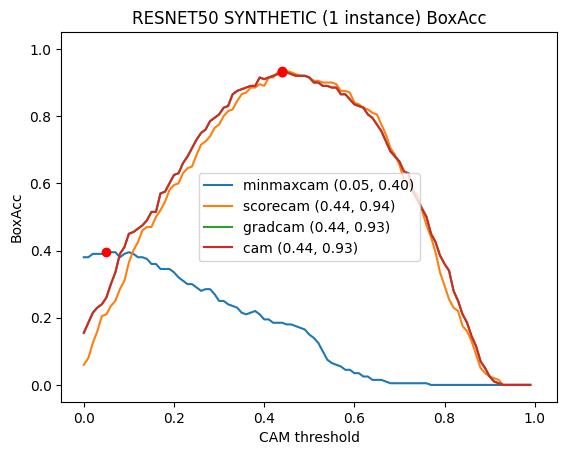

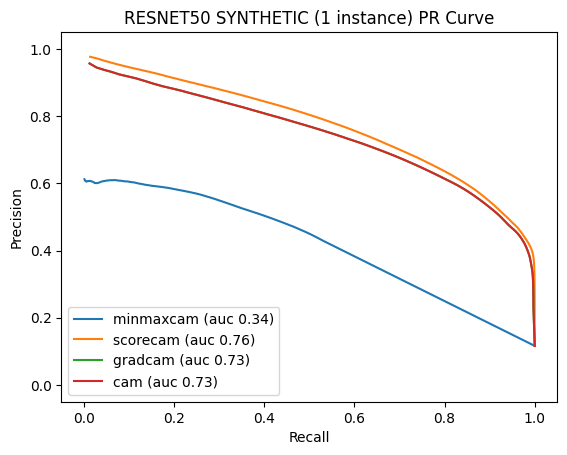

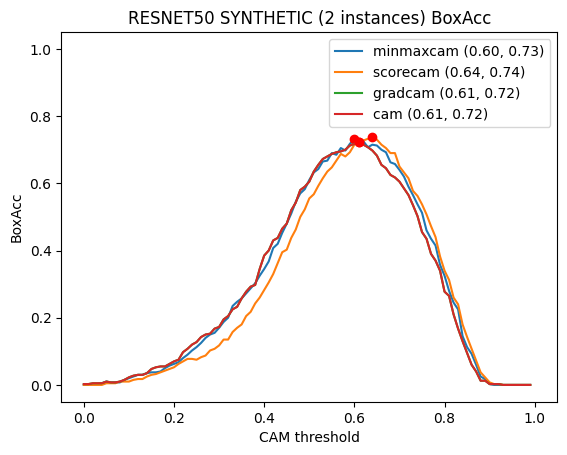

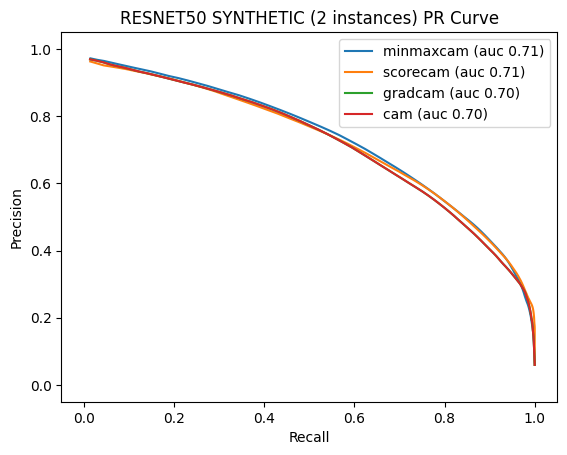

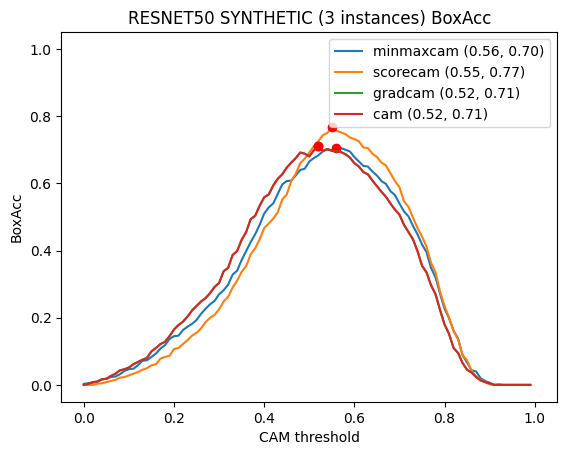

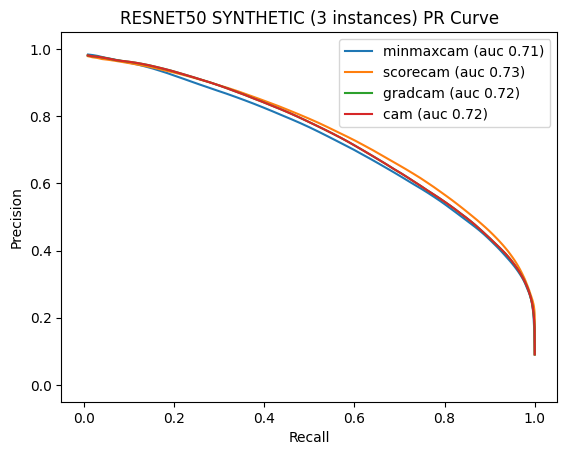

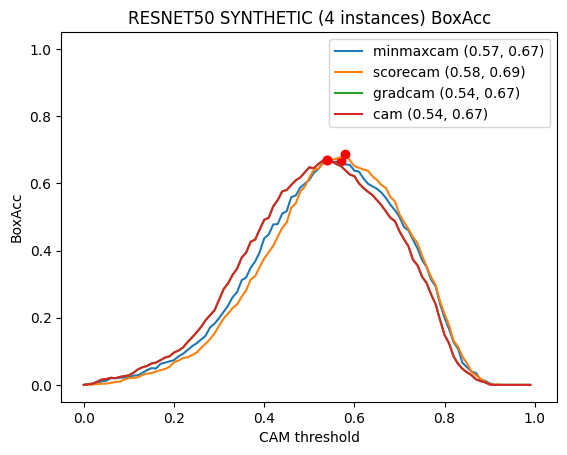

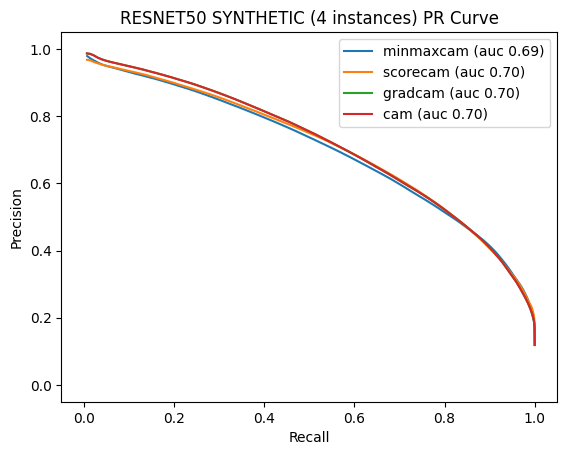

In [122]:
import numpy as np

for i in range(4):
    instances = i + 1
    spec = f"d{instances}b"
    boxacc, prcurve = get_mlflow_boxacc_prcurve(experiment_name=experiment_name, dataset=dataset, spec=spec, archtype='cam')
    # BoxAcc
    title = f"{architecture.upper()} {dataset} ({instances} instance{'s' if i else ''}) BoxAcc"
    plot_boxacc(boxacc, title=title, iou_thresholds=[50])
    # PR Curve
    title = f"{architecture.upper()} {dataset} ({instances} instance{'s' if i else ''}) PR Curve"
    plot_prcurve(prcurve, title)

### Training performance

In [92]:
dataset = 'SYNTHETIC'
spec = 'd1b'
archtype = 'cam'
experiment_name = 'wsol_resnet50_synthetic'
run_name = 'resnet50_minmaxcam_synthetic_d1b'
# run_id = '63fa71e18f4849a19f49b2923adf57a3'
# run_id = 'e6f2d6ba4ca24e31ba7b57c2e2d0266b'
filter_string = f'tags.mlflow.runName = "{run_name}"'
runs = get_runs(experiment_name, filter_string=filter_string)
run_id = runs['run_id'][0]

In [93]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val_optimal_threshold_IOU_70,metrics.train_accuracy,metrics.test_PxAP,metrics.test_optimal_threshold_IOU_30,...,tags.mlflow.log-model.history,tags.num_classes,tags.train,tags.model,tags.mlflow.source.name-e,tags.pretrained,tags.dataset,tags.train_augment,tags.dataset_spec,tags.architecture
0,6dcc4de27f924438aec2e5fa9c4cc642,965153792060422881,FINISHED,file:///users/goemaereg/github.com/thesis/mlru...,2023-02-28 14:19:09.861000+00:00,2023-02-28 14:29:35.702000+00:00,0.0,1.0,0.344443,0.02,...,"[{""run_id"": ""6dcc4de27f924438aec2e5fa9c4cc642""...",9,True,ResNetCam,/project/thesis,True,SYNTHETIC,True,d1b,resnet50


In [94]:
from mlflow import MlflowClient

client = MlflowClient()
val_accuracy = [metric.value for metric in client.get_metric_history(run_id, 'val_accuracy')]
steps = list(range(len(val_accuracy)))
val_maxboxaccv3 = [metric.value for metric in client.get_metric_history(run_id, 'val_MaxBoxAccV3')]
val_pxap = [metric.value for metric in client.get_metric_history(run_id, 'val_PxAP')]

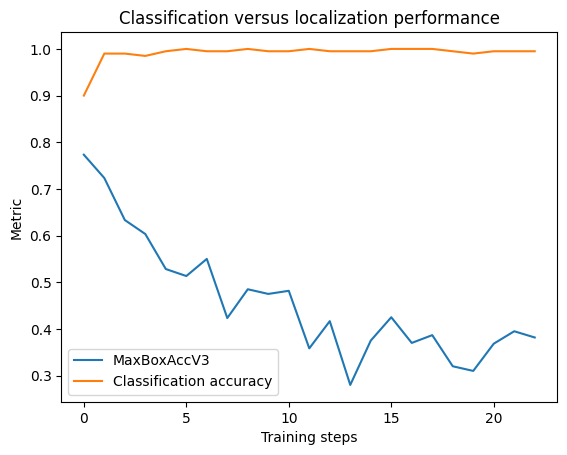

In [95]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()

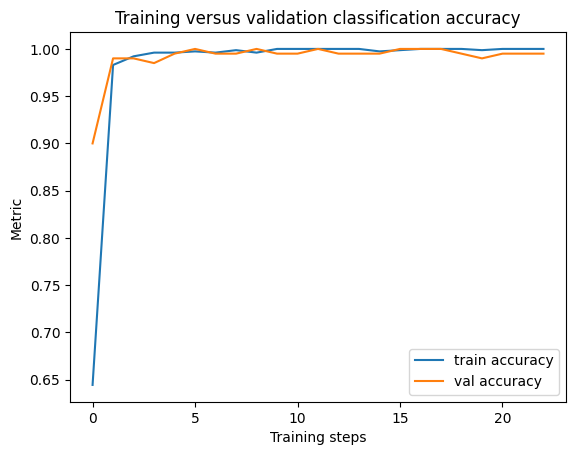

In [96]:
train_accuracy = [metric.value for metric in client.get_metric_history(run_id, 'train_accuracy')]
plt.plot(steps, train_accuracy, label='train accuracy')
plt.plot(steps, val_accuracy, label='val accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Training versus validation classification accuracy')
plt.legend()
plt.show()

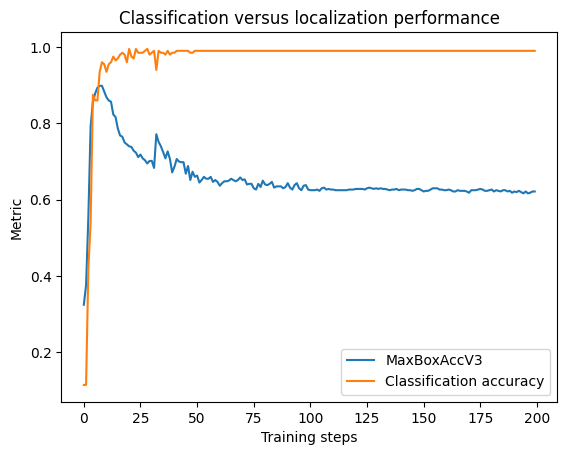

In [129]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()

In [97]:
iou_thresholds = [30, 50, 70]
iou_boxacc, _ = get_mlflow_boxacc_prcurve(experiment_name=experiment_name,dataset=dataset, spec=spec, archtype=archtype, method='minmaxcam')

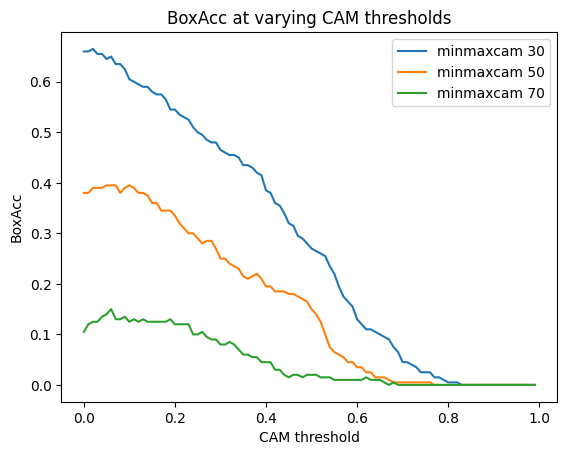

In [98]:
for method, iou_values in iou_boxacc.items():
    for iou_threshold, boxacc in iou_values.items():
        label = f'{method} {iou_threshold}'
        plt.plot(boxacc['cam_threshold'], boxacc['box_accuracy'], label = label)
plt.xlabel("CAM threshold")
plt.ylabel("BoxAcc")
plt.title('BoxAcc at varying CAM thresholds')
plt.legend()
plt.show()

In [152]:
def normalize_scoremap(cam):
    """
    Args:
        cam: numpy.ndarray(size=(H, W), dtype=np.float)
    Returns:
        numpy.ndarray(size=(H, W), dtype=np.float) between 0 and 1.
        If input array is constant, a zero-array is returned.
    """
    if np.isnan(cam).any():
        return np.zeros_like(cam)
    if cam.min() == cam.max():
        return np.zeros_like(cam)
    cam -= cam.min()
    cam /= cam.max()
    return cam

In [180]:
import numpy as np
import cv2

path_scoremap = '../val_log/vgg16_gap_cam_synthetic_d2b/scoremaps/test/SYNTHETIC_d_2_b_test_111.png.npy'
path_gtmask = '../data/maskdata/SYNTHETIC/d_2_b/test/SYNTHETIC_d_2_b_test_111.png'
path_image = '../data/dataset/SYNTHETIC/d_2_b/test/SYNTHETIC_d_2_b_test_111.png'
path_overlay = 'overlay.png'

image_shape = (512, 512, 3)
img = cv2.imread(path_image) # color channels in BGR format
scoremap = np.load(path_scoremap)
cam = cv2.resize(scoremap, image_shape[:2], interpolation=cv2.INTER_CUBIC)
cam = normalize_scoremap(cam)
cam_threshold_optimal = 0.74
cam_mask = cam >= cam_threshold_optimal

In [182]:
segment_cam = np.zeros(shape=image_shape)
segment_cam[cam_mask] = (0, 0, 255)  # BGR
segment_gt = np.zeros(shape=image_shape)
segment_gt_image = cv2.imread(path_gtmask) # color channels in BGR format
gt_mask = segment_gt_image > 0
segment_gt[gt_mask[:,:,0]] = (0, 255, 0)
image = segment_gt * 0.3 + segment_cam * 0.3 + img * 0.4
cv2.imwrite(path_overlay, image)

True